# Model Development

In this notebook, we will develop a Kriging model using the `NYS Oil & Gas Wells` to predict optimal drilling locations for oil and gas in **New York State**. Using geological and production data, we will explore spatial interpolation techniques to accurately estimate potential production sites. The process will involve building the Kriging model and refining it through regularization and hyperparameter tuning.

By the end of this notebook, we will have established a robust model ready for evaluation, aiming to identify the most effective approach for predicting where to drill for oil and gas.

### Loading Tools and Data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy.signal import detrend
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from skgstat import Variogram, OrdinaryKriging
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import pprint, pickle, warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df = pd.read_csv('../data/clean_gaswells.csv')
print('gas_prod\n------------')
print(df['gas_prod'].describe())
print('------------')
print(df.info())

df_saved = df.copy()
df.head()

gas_prod
------------
count    3,691.00
mean    13,417.05
std      8,529.29
min      2,168.00
25%      5,756.00
50%     11,598.00
75%     20,423.50
max     31,710.00
Name: gas_prod, dtype: float64
------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_prod   3691 non-null   float64
 1   well       3691 non-null   object 
 2   status     3691 non-null   object 
 3   depth      3691 non-null   float64
 4   elevation  3691 non-null   float64
 5   longitude  3691 non-null   float64
 6   latitude   3691 non-null   float64
 7   field      3691 non-null   object 
 8   geology    3691 non-null   object 
dtypes: float64(5), object(4)
memory usage: 259.6+ KB
None


,gas_prod,well,status,depth,elevation,longitude,latitude,field,geology
0,"5,455.00",gas development,plugged abandoned,"1,294.00",851.00,-78.48,42.94,Alden-Lancaster,Medina
1,"4,741.00",gas development,plugged abandoned,"1,818.00",535.00,-76.66,42.89,West Auburn,Queenston
2,"28,116.00",gas development,inactive,"1,425.00",640.00,-78.92,42.73,Orchard Park-Hamburg,Medina
3,"4,226.00",gas extension,plugged abandoned,"3,450.00","1,283.00",-79.31,42.27,Cassadaga Creek,Upper Devonian
4,"4,966.00",oil wildcat,active,"4,500.00","1,780.00",-79.59,42.05,Clymer,Bass Island


## Detrend

### Detrend Testing

#### Base Variogram - No Detrend

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 7142902.235309429,
 'normalized_sill': 9688786638300224.0,
 'normalized_nugget': 0,
 'effective_range': 1146.3492556381723,
 'sill': 86015272.76729384,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


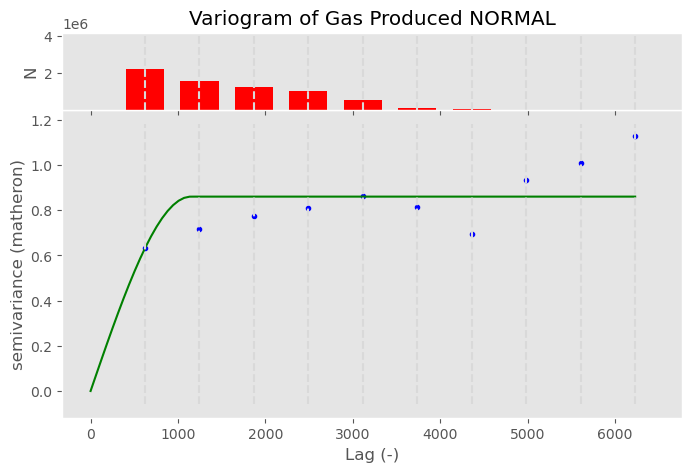

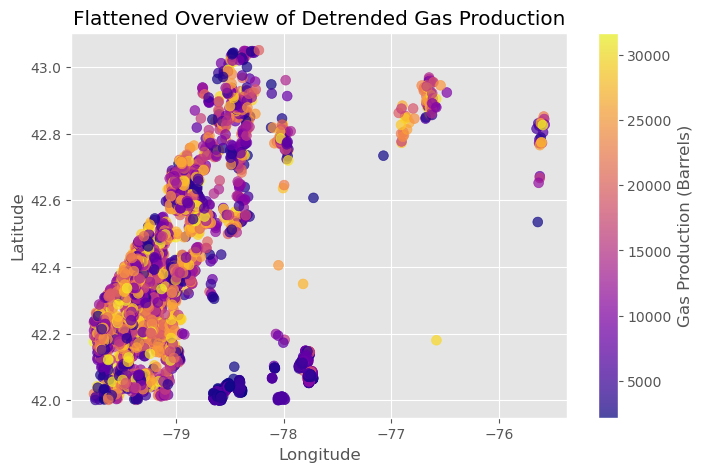

In [10]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_prod'])

gas_variogram = Variogram(coordinates=coordinates, values=target)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced NORMAL')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(target), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Signal Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 7049657.284323096,
 'normalized_sill': 9498359407761002.0,
 'normalized_nugget': 0,
 'effective_range': 1131.3845708876509,
 'sill': 84982515.36180834,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


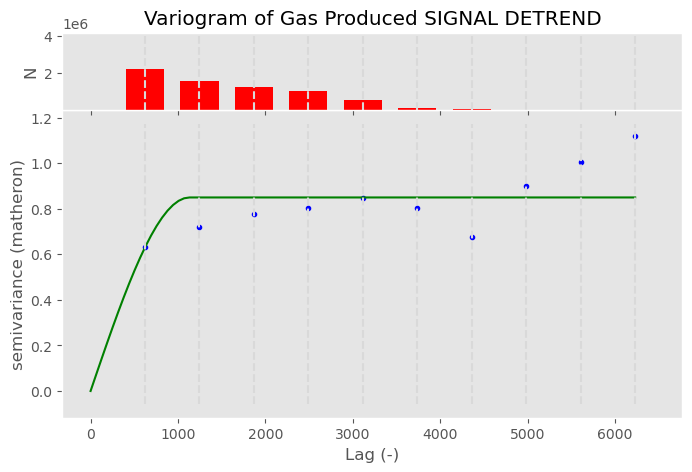

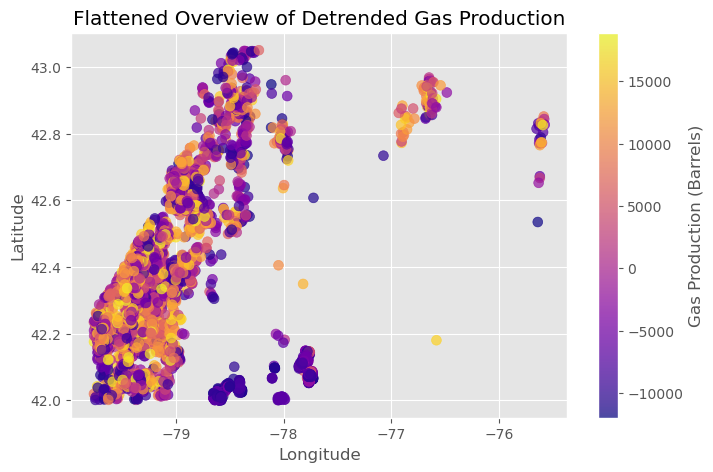

In [11]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_prod'])

detrended_gas = detrend(target)

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced SIGNAL DETREND')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(detrended_gas), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Pandas Diff Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 5560154.482473231,
 'normalized_sill': 1.7278946428486528e+16,
 'normalized_nugget': 0,
 'effective_range': 892.337420034746,
 'sill': 108780413.52693948,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


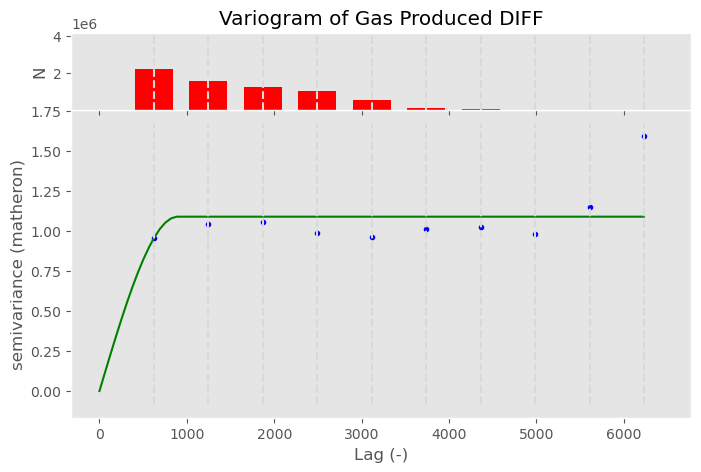

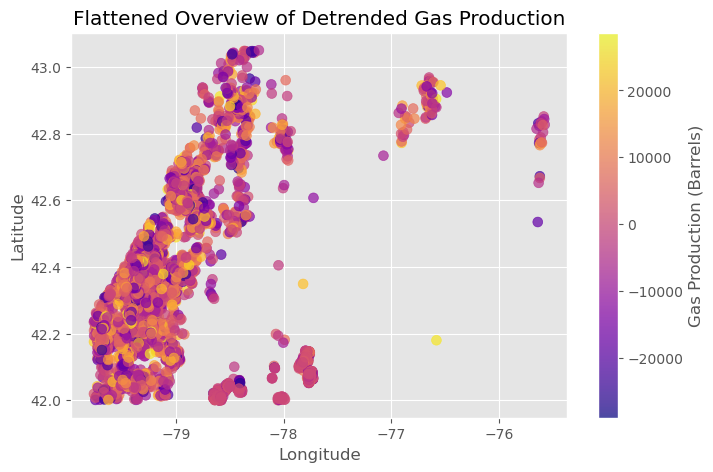

In [12]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_prod'])

detrended_gas = df['gas_prod'].diff().dropna()
coordinates = coordinates[1:]

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced DIFF')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude'][1:]), np.array(df['latitude'][1:]), 
                       s=50, c=np.array(detrended_gas), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Linear Regression Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 3841373.8831975153,
 'normalized_sill': 3184858098080612.5,
 'normalized_nugget': 0,
 'effective_range': 616.4939609369617,
 'sill': 53628022.28068241,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


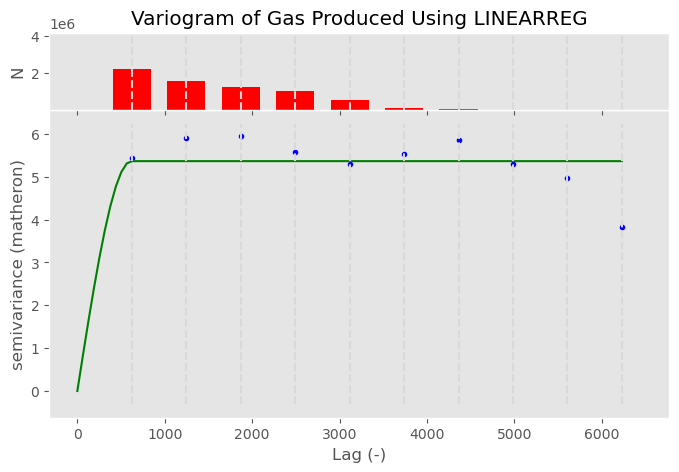

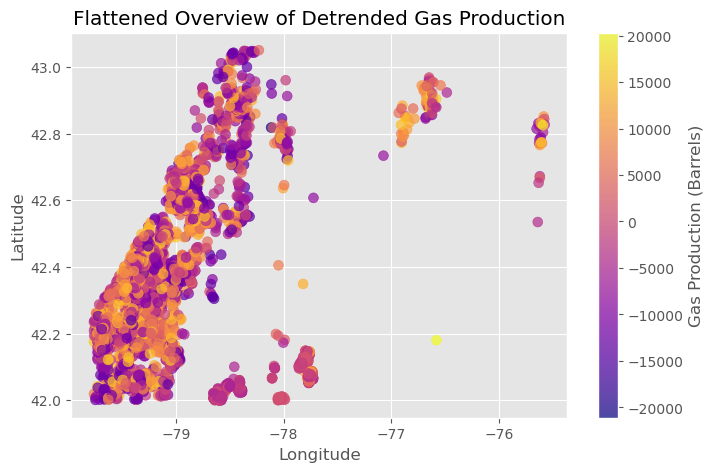

In [13]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_prod'])

reg = LinearRegression().fit(coordinates, target)
trend = reg.predict(coordinates)
detrended_gas = target - trend

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced Using LINEARREG')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(detrended_gas), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Polynomial Regression Detrended Variogram

{'dist_func': 'euclidean',
 'effective_range': 829.0063364029803,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 5165538.4990694,
 'normalized_nugget': 0,
 'normalized_sill': 3818016937871026.5,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 57628433.24953605}


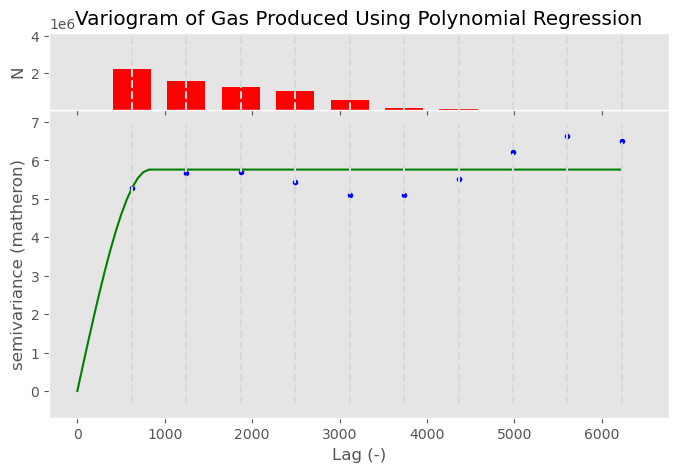

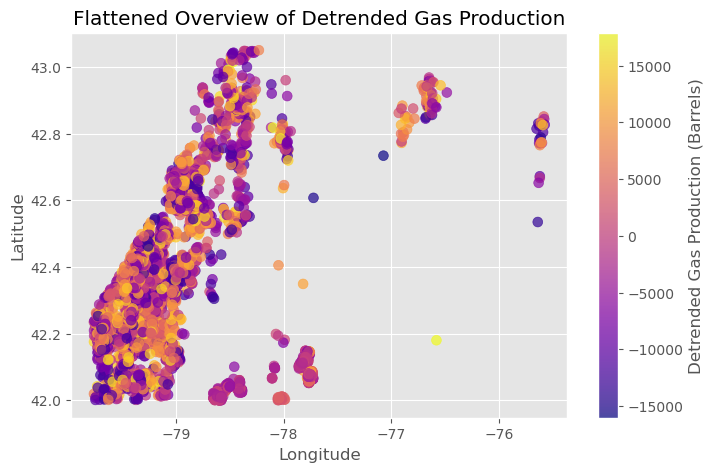

In [14]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_prod'])

poly = PolynomialFeatures(degree=2, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pprint(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced Using Polynomial Regression')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(df['longitude'], df['latitude'], 
                       s=50, c=detrended_gas, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Detrended Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Detrend Preprocessing

##### `Polynomial regression is the best method for detrending as shown by the sill of 13, which is comparable to the linear regression at 28. Although the polynomial regression exhibited a more significant drop in sill value compared to the linear regression, the variogram still shows a gradual increase in semivariance as lag distance increases. This suggests that despite the reduction in correlation, the polynomial regression still retains a sense of spatial correlation that appears genuine and reflective of the true underlying spatial structure.`

#### Detrend Build

In [8]:
df_original = df_saved.copy()
df_detrended = df_saved.copy()

df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

poly = PolynomialFeatures(degree=2, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

min_value = detrended_gas.min()
constant = abs(min_value) + 1
shifted_detrended_gas = detrended_gas + constant

df_detrended['gas_log1p'] = shifted_detrended_gas
df_detrended.rename(columns={'gas_log1p':'gas_log1p_dtsft'}, inplace=True)
print(df_detrended.describe())
df_detrended

       gas_log1p_dtsft     depth  elevation  longitude  latitude
count         7,377.00  7,377.00   7,377.00   7,377.00  7,377.00
mean             12.58  2,559.31   1,462.73     -78.73     42.31
std               1.65  1,219.57     455.58       0.75      0.29
min               1.00    181.00       8.00     -79.76     42.00
25%              11.81  1,580.00   1,210.00     -79.27     42.05
50%              12.83  2,316.00   1,520.00     -78.88     42.20
75%              13.59  3,600.00   1,770.00     -78.46     42.51
max              18.32 11,145.00   2,576.00     -75.42     43.56


,gas_log1p_dtsft,well,status,depth,elevation,longitude,latitude,field,geology
0,10.50,oil development,active,"1,396.00","1,685.00",-78.60,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
1,10.71,oil development,active,"1,280.00","1,640.00",-78.61,42.01,Bradford,Bradford Second
2,10.40,oil development,plugged abandoned,"1,505.00","1,870.00",-78.59,42.00,Bradford,"Chipmunk, Bradford 2nd & 3rd"
3,10.32,oil development,active,"1,486.00","1,850.00",-78.60,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
4,10.53,oil development,active,"1,379.00","1,710.00",-78.61,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
...,...,...,...,...,...,...,...,...,...
7372,13.57,gas development,active,"2,066.00",630.00,-76.64,42.90,West Auburn,Queenston
7373,11.48,gas extension,active,"2,393.00",770.00,-76.58,42.88,West Auburn,Queenston
7374,13.79,gas extension,active,"2,540.00",838.00,-76.61,42.85,West Auburn,Queenston
7375,13.69,gas extension,active,"2,487.00",825.00,-76.63,42.84,West Auburn,Queenston


In [9]:
len(df_detrended.columns)

9

In [10]:
df_detrended = df_detrended[['gas_log1p_dtsft','depth','elevation','longitude','latitude',
              'well','status','field','geology']]
df_detrended.head()

,gas_log1p_dtsft,depth,elevation,longitude,latitude,well,status,field,geology
0,10.50,"1,396.00","1,685.00",-78.60,42.01,oil development,active,Bradford,"Chipmunk, Bradford 2nd & 3rd"
1,10.71,"1,280.00","1,640.00",-78.61,42.01,oil development,active,Bradford,Bradford Second
2,10.40,"1,505.00","1,870.00",-78.59,42.00,oil development,plugged abandoned,Bradford,"Chipmunk, Bradford 2nd & 3rd"
3,10.32,"1,486.00","1,850.00",-78.60,42.01,oil development,active,Bradford,"Chipmunk, Bradford 2nd & 3rd"
4,10.53,"1,379.00","1,710.00",-78.61,42.01,oil development,active,Bradford,"Chipmunk, Bradford 2nd & 3rd"


#### Detrend Plot

{'dist_func': 'euclidean',
 'effective_range': 10964.000198146836,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 120209300.34496388,
 'normalized_nugget': 0,
 'normalized_sill': 286.25207262666606,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 13.435263069186574}


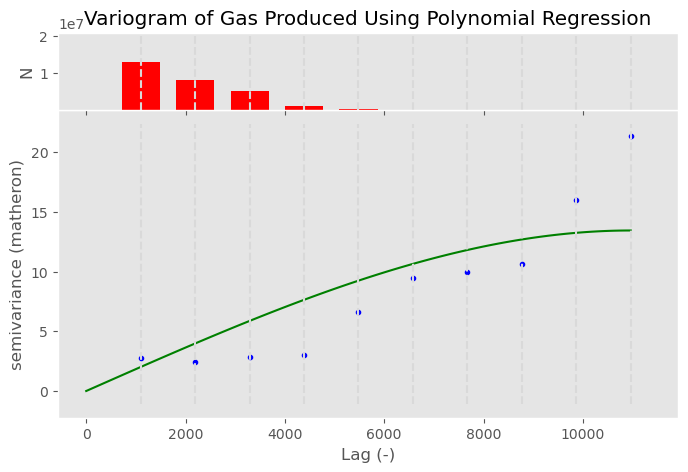

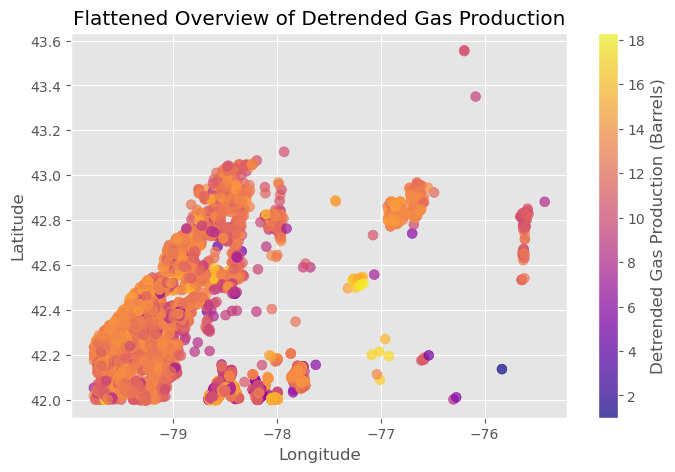

In [11]:
df = df_detrended.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p_dtsft'])

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pprint(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced Using Polynomial Regression')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(df['longitude'], df['latitude'], 
                       s=50, c=df['gas_log1p_dtsft'], cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Detrended Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

## Preprocessing by Encoding Data

In [12]:
df = df_detrended.copy()
target = df['gas_log1p_dtsft']

numerical = ['gas_log1p_dtsft','depth','elevation','longitude','latitude']
categorical = ['well','status','field','geology']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical),
        ('cat', OneHotEncoder(sparse_output=False), categorical)])

df_transformed = preprocessor.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed, columns=preprocessor.get_feature_names_out())
df_transformed.to_csv('../data/encoded_gaswells.csv', index=False)
df_transformed

,num__gas_log1p_dtsft,num__depth,num__elevation,num__longitude,num__latitude,cat__well_dry wildcat,cat__well_gas development,cat__well_gas extension,cat__well_gas wildcat,cat__well_oil development,cat__well_oil extension,cat__well_oil wildcat,cat__status_active,cat__status_drilling complete,cat__status_inactive,cat__status_plugged abandoned,cat__status_shut in,cat__field_Akron,cat__field_Alden-Lancaster,cat__field_Alexander,cat__field_Alfred,cat__field_Allen,cat__field_Andover,cat__field_Apple Core,cat__field_Ashford,cat__field_Attica,cat__field_Auburn,cat__field_Beans Station,cat__field_Beaver Meadow - Herkimer pool,cat__field_Beaver Meadow - Vernon pool,cat__field_Beech Hill,cat__field_Beech Hill-Independence,cat__field_Bergen,cat__field_Bethany,cat__field_Bixby Hill,cat__field_Bockhahn,cat__field_Bradford,cat__field_Bradley Brook,cat__field_Bradley Brook - Herkimer pool,cat__field_Bradley Brook - Vernon pool,cat__field_Brant-Eden,cat__field_Buffalo,cat__field_Buffalo Creek,cat__field_Busti,cat__field_Cagwin,cat__field_Cascade Brook,cat__field_Cassadaga Creek,cat__field_Castile,cat__field_Central Wales,cat__field_Ceres,cat__field_Chaffee-Arcade,cat__field_Chestnut Ridge,cat__field_Chipmunk,cat__field_Clarksville,cat__field_Clymer,cat__field_Concord,cat__field_Connoisarauley Creek,cat__field_Corbin Hill,cat__field_County Line,cat__field_Cowlesville,cat__field_Danley Corners,cat__field_Dansville,cat__field_Dayton,cat__field_Doolittle Hill,cat__field_Dublin Hollow,cat__field_Dutch Hollow,cat__field_East Aurora,cat__field_East Bloomfield,cat__field_East Otto,cat__field_Ellery,cat__field_Ellicotville,cat__field_Elma,cat__field_Fayette-Waterloo,cat__field_Five Mile,cat__field_Folsom Creek,cat__field_Ford's Brook,cat__field_Four Mile,cat__field_Fulmer Valley,cat__field_Gerry-Charlotte,cat__field_Glenwood,cat__field_Glodes Corners Road,cat__field_Gordon Brook,cat__field_Great Valley,cat__field_Hannon,cat__field_Harmony,cat__field_Hog Hollow,cat__field_Huron Creek,cat__field_Indian Creek,cat__field_Indian Falls,cat__field_Java,cat__field_Karr Valley,cat__field_Lakeshore,cat__field_Lakeview,cat__field_Lebanon,cat__field_Leicester,cat__field_Little France,cat__field_Little Valley,cat__field_Longhorn,cat__field_Longhorn - Hamilton Pool,cat__field_Longhorn - Oneida Pool,cat__field_Muck Farm,cat__field_Mud Creek,cat__field_New Field Wildcat,cat__field_Nile,cat__field_North Collins,cat__field_North Harmony,cat__field_North Penn Yan,cat__field_Northwoods,cat__field_Not Applicable,cat__field_Olean,cat__field_Orchard Park-Hamburg,cat__field_Pavilion,cat__field_Pigeon Hill,cat__field_Pike Corners,cat__field_Pulaski,cat__field_Quackenbush Hill,cat__field_Reeder Creek,cat__field_Richburg,cat__field_Rushford,cat__field_Sangerfield,cat__field_Sardinia,cat__field_Sharon,cat__field_Sheldon,cat__field_Silver Lake,cat__field_Snyders Corners Pool,cat__field_South Corning,cat__field_Sparta,cat__field_Sprague Hill,cat__field_Stagecoach,cat__field_Tozier's Corners,cat__field_Uhley Corners-Caledonia,cat__field_Utley Brook,cat__field_Van Etten,cat__field_Wales,cat__field_Wells College,cat__field_West Auburn,cat__field_West Seneca,cat__field_West Union,cat__field_Whiskey Creek,cat__field_Wilson Hollow,cat__field_Wyoming,cat__geology_Akron,cat__geology_Bass Island,cat__geology_Black River,cat__geology_Bradford,cat__geology_Bradford & Chipmunk,cat__geology_Bradford 1st & 2nd,cat__geology_Bradford 1st & Chipmunk,cat__geology_Bradford 2nd & 3rd,cat__geology_Bradford Second,cat__geology_Bradford Third,cat__geology_Camillus,cat__geology_Chipmunk,cat__geology_Chipmunk & Bradford 2nd,cat__geology_Chipmunk & Bradford 3rd,cat__geology_Chipmunk & Harrisburg,"cat__geology_Chipmunk, Bradford 1st & 2nd","cat__geology_Chipmunk, Bradford 1st,2nd,3rd","cat__geology_Chipmunk, Bradford 2nd & 3rd",cat__geology_Clarksville,cat__geology_Clinton,cat__geology_Devonian Shale,cat__geology_Fulmer Valley,cat__geology_Glade,cat__geology_Grimsby,cat__geology_Hamilton,cat__geology_Helderb

In [13]:
df = df_transformed.copy()
print(df.shape)

train, test = train_test_split(df, test_size=0.25, random_state=42)

x_train = np.array(train['num__longitude'].values)
y_train = np.array(train['num__latitude'].values)
h_train = np.array(train['num__depth'].values)
v_train = np.array(train['num__gas_log1p_dtsft'].values)

x_test = np.array(test['num__longitude'].values)
y_test = np.array(test['num__latitude'].values)
h_test = np.array(test['num__depth'].values)
v_test = np.array(test['num__gas_log1p_dtsft'].values)

gridx_train = np.linspace(x_train.min(), x_train.max(), 25)
gridy_train = np.linspace(y_train.min(), y_train.max(), 25)
gridh_train = np.linspace(h_train.min(), h_train.max(), 25)

gridx_test = np.linspace(x_test.min(), x_test.max(), 25)
gridy_test = np.linspace(y_test.min(), y_test.max(), 25)
gridh_test = np.linspace(h_test.min(), h_test.max(), 25)

print(f'\
train_test_split shapes\n------------\n\
x_train:   {x_train.shape}\n\
y_train:   {y_train.shape}\n\
h_train:   {h_train.shape}\n\
v_train:   {v_train.shape}\n\
x_test:    {x_test.shape}\n\
y_test:    {y_test.shape}\n\
h_test:    {h_test.shape}\n\
v_test:    {v_test.shape}\n\n\
gridx_tr:  {gridx_train.shape}\n\
gridy_tr:  {gridy_train.shape}\n\
gridh_tr:  {gridh_train.shape}\n\
gridx_ts:  {gridx_test.shape}\n\
gridy_ts:  {gridy_test.shape}\n\
gridh_ts:  {gridh_test.shape}')

(7377, 197)
train_test_split shapes
------------
x_train:   (5532,)
y_train:   (5532,)
h_train:   (5532,)
v_train:   (5532,)
x_test:    (1845,)
y_test:    (1845,)
h_test:    (1845,)
v_test:    (1845,)

gridx_tr:  (25,)
gridy_tr:  (25,)
gridh_tr:  (25,)
gridx_ts:  (25,)
gridy_ts:  (25,)
gridh_ts:  (25,)


## Ordinary Kriging 3D

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 13.184188237337827
Full Sill: 13.184188237337827
Range: 9551.974302205945
Nugget: 2.990068673978759e-17 



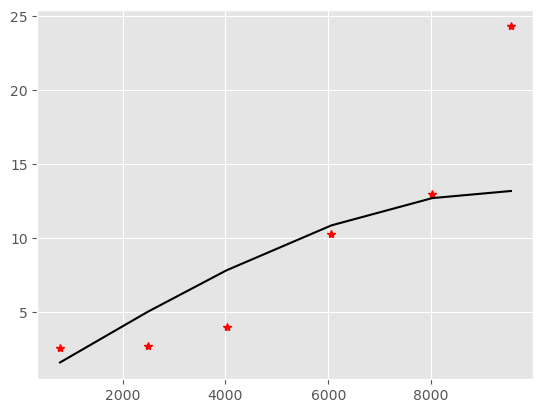

Calculating statistics on variogram model fit...


In [ ]:
ok3d = OrdinaryKriging3D(
    x_train,
    y_train,
    h_train,
    v_train,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True,
    pseudo_inv=True,
    pseudo_inv_type='pinv'
)

z_train3d, s2_train3d = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
pred, error = ok3d.execute('points', x_test, y_test, h_test)

rmse = np.sqrt(mean_squared_error(v_test, pred))
mae = mean_absolute_error(v_test, pred)
r2 = r2_score(v_test, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

with open('../model/kriging3d.pkl', 'wb') as file:
    pickle.dump(ok3d, file)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
slice_index = z_train3d.shape[2] // 2

im1 = ax1.imshow(z_train3d[:,:,slice_index], cmap='plasma', interpolation='bilinear', vmin=z_train3d.min(), vmax=z_train3d.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train3d[:,:,slice_index], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

plt.show()
plt.close()

## Plots 3D

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(x_train, y_train, h_train, c=v_train, cmap='plasma', marker='o')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
ax.invert_zaxis()
ax.set_title('3D Kriging Scatter Plot')
fig.colorbar(sc, ax=ax, label='Gas Production')

plt.show()


In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for a specific depth slice
X, Y = np.meshgrid(gridx_train, gridy_train)
Z = z_train3d[:, :, slice_index]

# Flatten the meshgrid and Z values for the scatter plot
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Scatter plot
sc = ax.scatter(X_flat, Y_flat, gridh_train[slice_index], c=Z_flat, cmap='plasma', marker='o')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
ax.invert_zaxis()  # Invert the z-axis if depth should increase downwards
ax.set_title('3D Kriging Scatter Plot')
fig.colorbar(sc, ax=ax, label='Gas Production')

plt.show()


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot slices at different depths
for i, ax in enumerate(axes):
    slice_index = i * (z_train3d.shape[2] // 3)
    im = ax.imshow(z_train3d[:, :, slice_index], cmap='viridis', interpolation='bilinear',
                   extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()),
                   origin='lower')
    ax.set_title(f'Slice at depth index {slice_index}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Gas Production')

plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Average over the depth axis to create a 2D surface
Z = np.mean(z_train3d, axis=2)  # Average over the depth axis
X, Y = np.meshgrid(gridx_train, gridy_train)

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Gas Production')
ax.set_title('Averaged 3D Kriging Interpolation')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for X and Y using a specific depth slice
slice_index = len(gridh_train) // 2  # Choose a slice index
X, Y = np.meshgrid(gridx_train, gridy_train)
Z = z_train3d[:, :, slice_index]  # Use the selected depth slice

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Gas Production')
ax.set_title('3D Kriging Interpolation at Depth Index {}'.format(slice_index))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


In [ ]:
import pyvista as pv
import numpy as np

# Ensure gridx_train, gridy_train, and gridh_train are properly defined
gridx_train = np.linspace(x_train.min(), x_train.max(), 25)
gridy_train = np.linspace(y_train.min(), y_train.max(), 25)
gridh_train = np.linspace(h_train.min(), h_train.max(), 25)

# Create a 3D meshgrid
X, Y, Z = np.meshgrid(gridx_train, gridy_train, gridh_train, indexing='ij')

# Create the StructuredGrid
grid = pv.StructuredGrid(X, Y, Z)

# Ensure z_train3d has the correct shape matching the grid
grid['values'] = z_train3d.ravel(order='F')

# Volume rendering
p = pv.Plotter()
p.add_volume(grid, scalars='values', cmap='plasma')
p.show()


In [ ]:
# import pyvista as pv

# # Check the data range
# min_val = z_train3d.min()
# max_val = z_train3d.max()
# mean_val = z_train3d.mean()

# print(f"Data range: {min_val} to {max_val}")

# # Adjust isosurface values based on the data range
# isosurface_values = [min_val + 0.1 * (max_val - min_val), mean_val, max_val - 0.1 * (max_val - min_val)]

# # Create a grid of points
# grid = pv.StructuredGrid()
# grid.points = np.c_[X.ravel(), Y.ravel(), Z.ravel()]
# grid["values"] = z_train3d.ravel()

# # Plot isosurfaces
# p = pv.Plotter()
# contours = grid.contour(isosurfaces=isosurface_values)
# p.add_mesh(contours, cmap="viridis")
# p.show()


## Hyperparameter Tuning

In [ ]:
# param_grid = {
#     'method': ['ordinary3d'],
#     'variogram_model': ['linear', 'power', 'gaussian', 'spherical', 'exponential'],
#     # 'nlags': [6, 10, 15],
#     # 'weight': [True, False],
#     # 'anisotropy_scaling': [(1.0, 1.5), (1.5, 2.0)],
#     # 'anisotropy_angle': [(0.0, 30.0, 60.0), (30.0, 45.0, 60.0)],
#     # 'exact_values': [True, False],
#     # 'pseudo_inv': [True, False],
#     # 'pseudo_inv_type': ['pinv', 'pinvh'],
#     # 'drift_terms': [None, ['regional_linear']] 
# }

# coordinates_train = np.vstack((x_train, y_train, h_train)).T
# coordinates_test = np.vstack((x_test, y_test, h_test)).T

# tuning = GridSearchCV(
#     Krige(), 
#     param_grid, 
#     cv=5, 
#     scoring='neg_root_mean_squared_error',
#     verbose=3, 
#     return_train_score=True,
#     n_jobs=-1 )

# tuning.fit(X=coordinates_train, y=v_train)

# best_params = tuning.best_params_
# best_score = tuning.best_score_
# best_model = tuning.best_estimator_

# pprint.pp(best_params, best_score)

# best_model.fit(coordinates_train, v_train)
# z_train, s2_train = best_model.execute('grid', gridx_train, gridy_train)
# z_test, s2_test = best_model.execute('grid', gridx_test, gridy_test)
# pred, error = best_model.execute('points', x_test, y_test)

# rmse = np.sqrt(mean_squared_error(v_test, pred))
# mae = mean_absolute_error(v_test, pred)
# r2 = r2_score(v_test, pred)

# print('\n------------\n')
# print("RMSE:", round(rmse, 3))
# print("MAE:", round(mae, 3))
# print("R2:", round(r2, 3))
# print('\n------------\n')

## Script

In [ ]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')